In [ ]:
!pip install mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 20.3 MB/s eta 0:00:00


In [ ]:
import mne, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import scipy.io
from scipy.signal import savgol_filter
import pywt
import matplotlib.pyplot as plt
from scipy.signal import spectrogram
import scipy.io
from mne.preprocessing import ICA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from scipy.signal import welch
from sklearn.metrics import classification_report
from scipy.signal import spectrogram
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import classification_report

**Signal Denoising, Wavelet Decomposition, and ICA for Artifact Removal**

In [ ]:
def process_data(data_path, sfreq, ch_names, ch_types, excluded_components):
    data = scipy.io.loadmat(data_path)
    try:
        np_arr = np.array(data['Data'])
    except KeyError:
        print("Key 'Data' not found in the.mat file.")
        return None

    info = mne.create_info(ch_names, sfreq, ch_types)
    raw = mne.io.RawArray(np_arr, info)
    raw.filter(0.5, 45)

    sg_filter = savgol_filter(raw.get_data(), 127, 5, axis=1)
    raw_data = raw.get_data() - sg_filter
    coeffs = pywt.wavedec(raw_data, 'db2', level=4, axis=1)
    raw_data = pywt.waverec(coeffs, 'db2', axis=1)
    raw = mne.io.RawArray(raw_data, info)

    raw.plot(n_channels=10, title='Raw EEG Signal Before ICA')

    ica = mne.preprocessing.ICA(n_components=20, random_state=0)
    ica.fit(raw)
    raw_ica = ica.apply(raw.copy())
    ica.plot_sources(raw_ica)
    raw_ica = ica.apply(raw_ica, exclude=excluded_components)
    ica.plot_sources(raw_ica)
    raw_ica.plot(n_channels=10, title='Raw EEG Signal After ICA')

    return raw, raw_ica

**Time-Domain and Frequency-Band Analysis with Overlapping Windows"**

In [ ]:
def extract_features(raw, sfreq, win_length_sec, overlap_sec):
    win_length_samples = int(win_length_sec * sfreq)
    overlap_samples = int(overlap_sec * sfreq)
    features_list = []
    for start in range(0, raw.get_data().shape[1] - win_length_samples + 1, overlap_samples):
        window = raw.get_data()[:, start:start+win_length_samples]
        mean_time = np.mean(window, axis=1)
        std_time = np.std(window, axis=1)
        psd, freqs = mne.time_frequency.psd_array_welch(window, sfreq, fmin=0.5, fmax=45., n_fft=sfreq)
        freq_res = freqs[1] - freqs[0]
        alpha_band = psd[:, (freqs>=8) & (freqs<=12)].mean(axis=1) * freq_res
        beta_band = psd[:, (freqs>=12) & (freqs<=30)].mean(axis=1) * freq_res
        features_list.append(np.column_stack([mean_time, std_time, alpha_band, beta_band]))
    features = np.concatenate(features_list)
    return features

**Training and Evaluating Logistic Regression for Classification Tasks**

In [ ]:
"""def classify_data(features, labels):
    # Split data into training and testing sets
    from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
for train_index, test_index in loo.split(features):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    # rest of your code

    #X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=0)

    # Train a Logistic Regression model and evaluate it
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Training accuracy: ", model.score(X_train, y_train))
    print("Testing accuracy: ", model.score(X_test, y_test))
    print(classification_report(y_test, y_pred))
    print(len(X_test))"""
"""def classify_data(features, labels):
    # Split data into training and testing sets
    loo = LeaveOneOut()
    for train_index, test_index in loo.split(features):
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # Train a Logistic Regression model and evaluate it
        model = LogisticRegression().fit(X_train, y_train)
        y_pred = model.predict(X_test)

        print("Training accuracy: ", model.score(X_train, y_train))
        print("Testing accuracy: ", model.score(X_test, y_test))
        print(classification_report(y_test, y_pred))
        print(len(X_test))"""

def classify_data(X_train, X_test, y_train, y_test):
    # Train a Logistic Regression model and evaluate it
    model = LogisticRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("Training accuracy: ", model.score(X_train, y_train))
    print("Testing accuracy: ", model.score(X_test, y_test))
    print(classification_report(y_test, y_pred))






**LOPO (Leave-One-Participant-Out)**

In [ ]:
sfreq = 128  # Sampling frequency
ch_names = ['CZ', 'FZ', 'Fp1', 'F7', 'F3', 'FC1', 'C3', 'FC5', 'FT9', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO9', 'O1', 'PZ', 'OZ', 'O2', 'PO10', 'P8', 'P4', 'CP2', 'CP6', 'T8', 'FT10', 'FC6', 'C4', 'FC2', 'F4', 'F8', 'Fp2']  # Channel names
ch_types = ['eeg'] * 32  # Channel types
excluded_components1 = [0,13,15,18,19]

'''data_paths_train = [ '/content/Relax_sub_6_trial2.mat','/content/Mirror_image_sub_6_trial2.mat', '/content/Stroop_sub_6_trial2.mat']'''
data_paths_train = ['/content/Mirror_image_sub_6_trial2.mat', '/content/Stroop_sub_6_trial2.mat']
data_path_relax = ['/content/Relax_sub_6_trial2.mat']

data_path_test = ['/content/Arithmetic_sub_6_trial2.mat']


**Feature Extraction and Label Assignment for Training Datasets in EEG Classification**

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


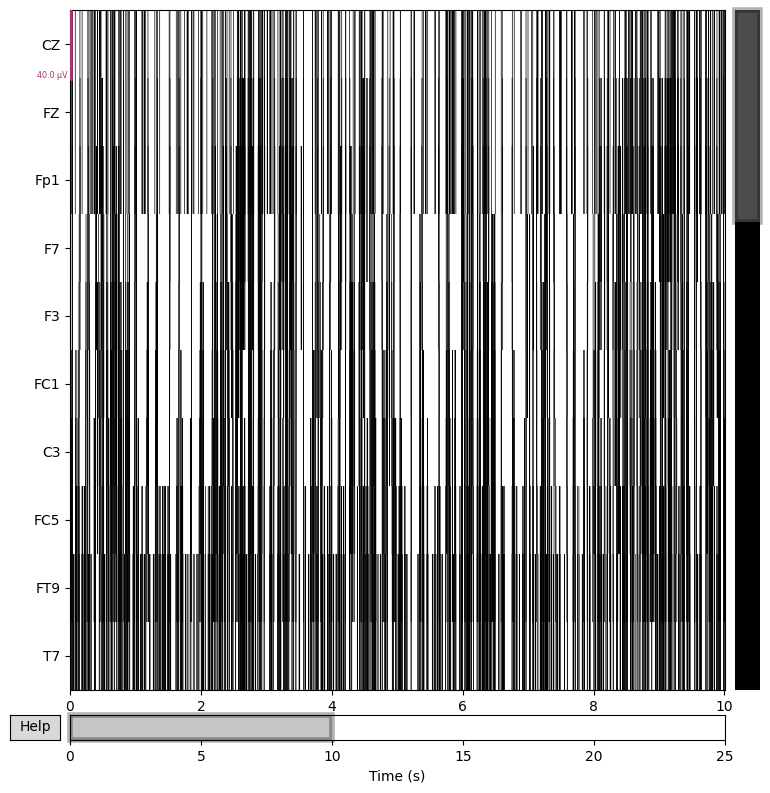

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


<ipython-input-40-a43e21f775be>:32: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 11.4s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


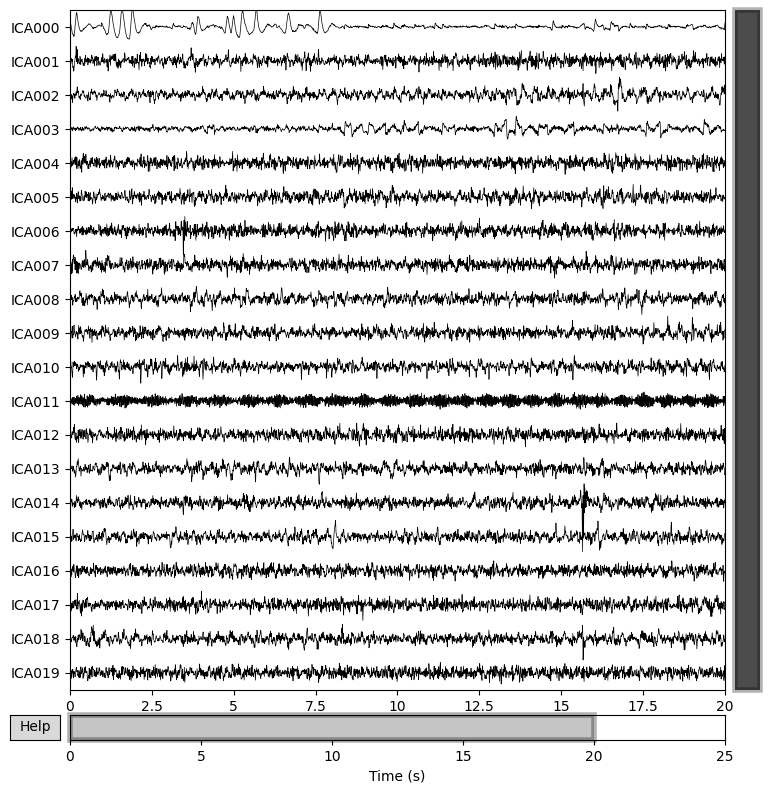

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


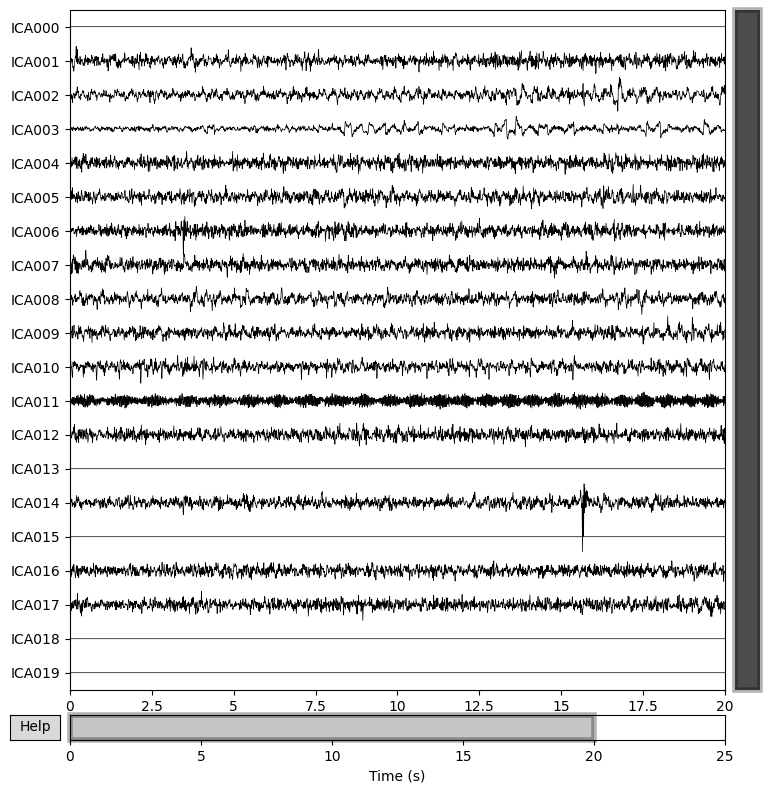

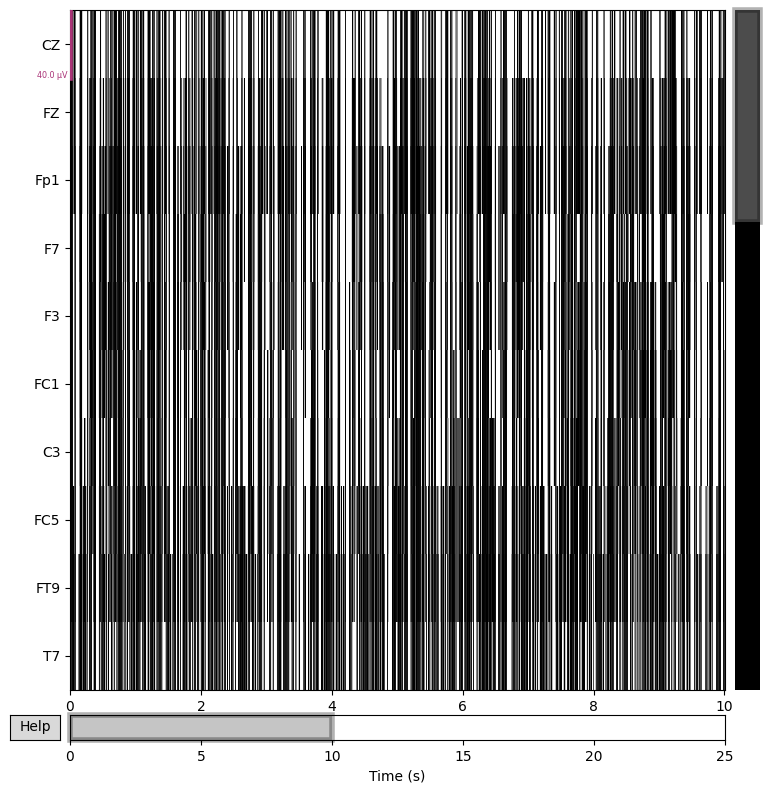

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective wind

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


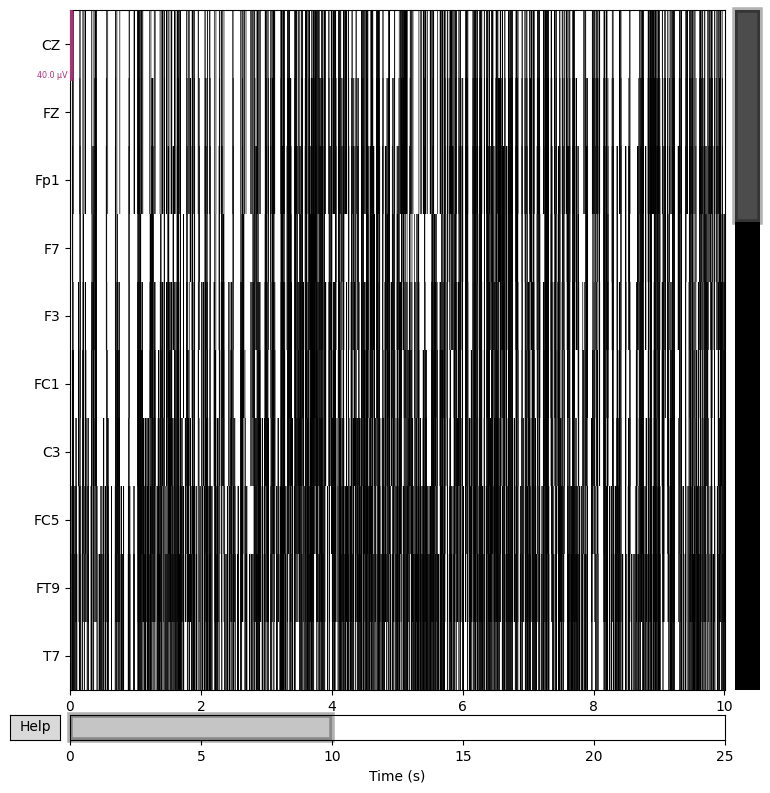

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


<ipython-input-40-a43e21f775be>:32: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 10.5s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


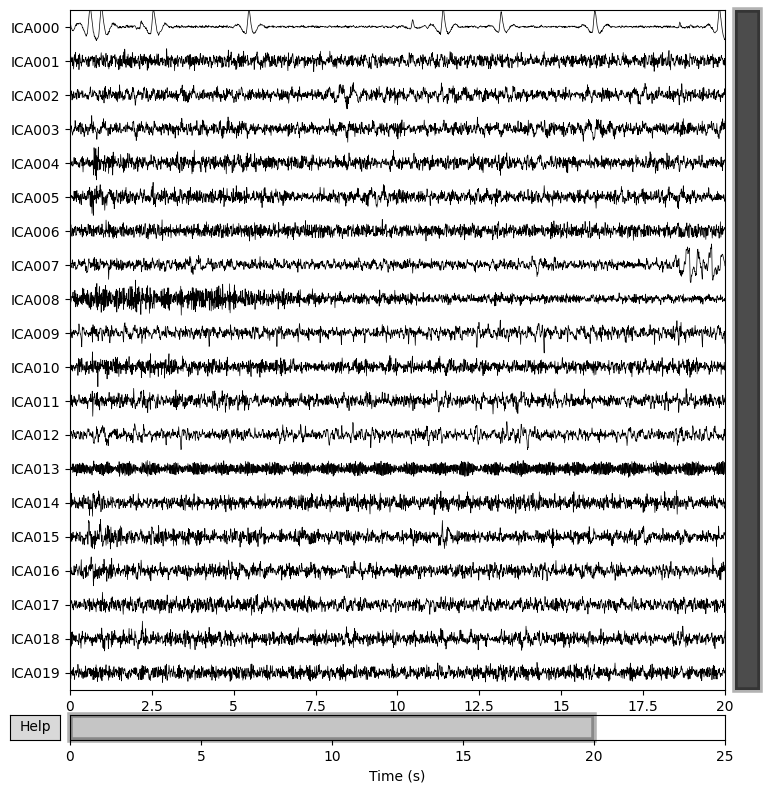

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


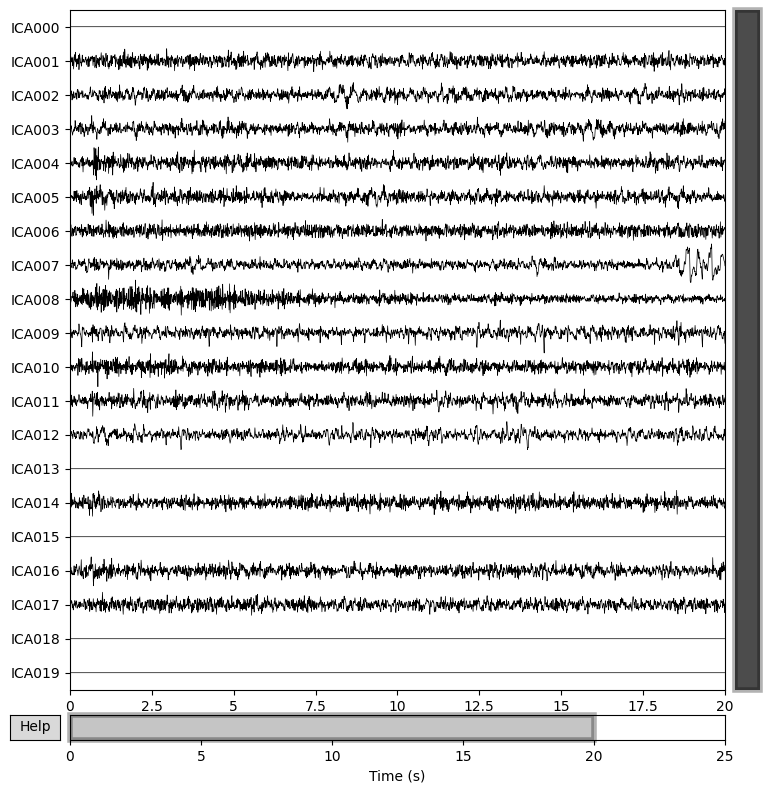

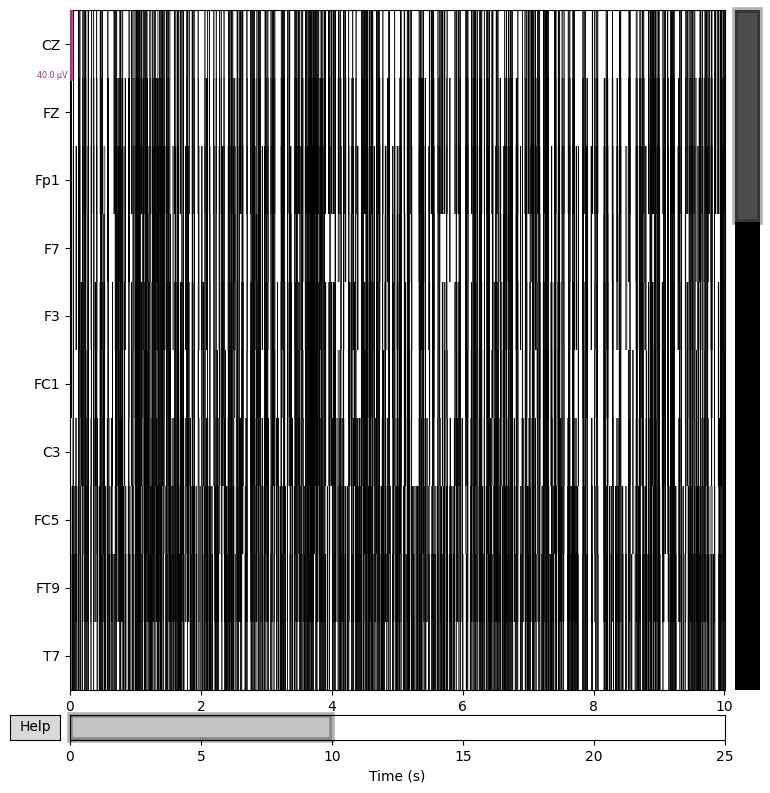

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective wind

In [ ]:
'''# Initialize lists to store features and labels
features_list_train = []
labels_list_train = []

# Process each training dataset
labels_values = [0, 1, 1]
for labels_values, data_path in enumerate(data_paths_train):
    raw, raw_ica = process_data(data_path, sfreq, ch_names, ch_types, excluded_components1)
    features = extract_features(raw_ica, sfreq, win_length_sec=1, overlap_sec=0.5)
    features_list_train.append(features)
    labels_list_train.append(labels_values * np.ones(features.shape[0]))
    print(labels_values * np.ones(features.shape[0]))'''

features_list_train = []
labels_list_train = []

labels_values = [ 1, 1]
for label_value, data_path in zip(labels_values, data_paths_train):
    raw, raw_ica = process_data(data_path, sfreq, ch_names, ch_types, excluded_components1)
    features = extract_features(raw_ica, sfreq, win_length_sec=1, overlap_sec=0.5)
    features_list_train.append(features)
    labels_list_train.append(label_value * np.ones(features.shape[0]))
    print(label_value * np.ones(features.shape[0]))






**Feature Extraction and Label Assignment for Training Datasets in EEG Classification**

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


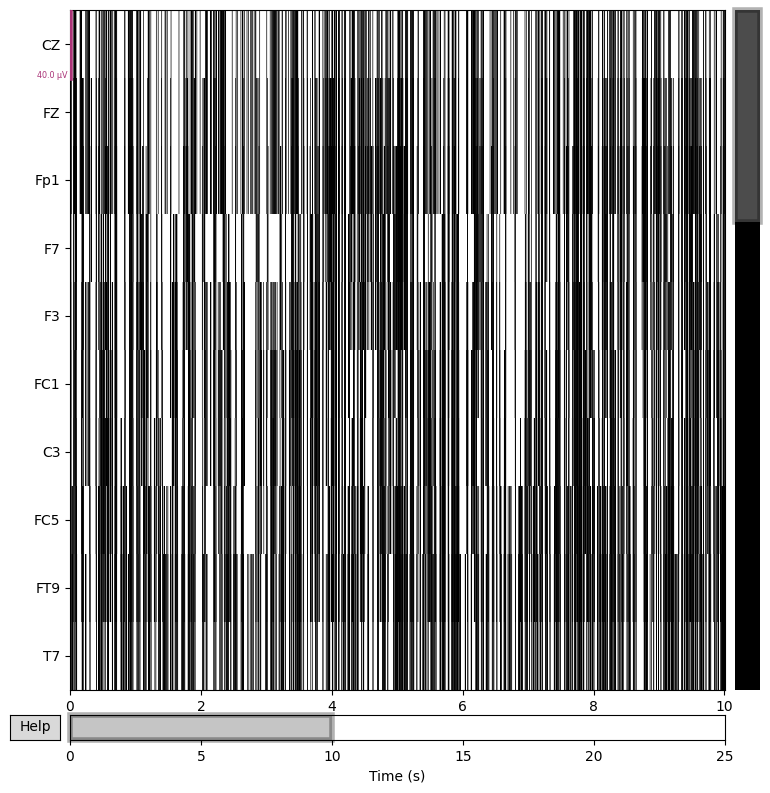

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


<ipython-input-40-a43e21f775be>:32: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 15.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


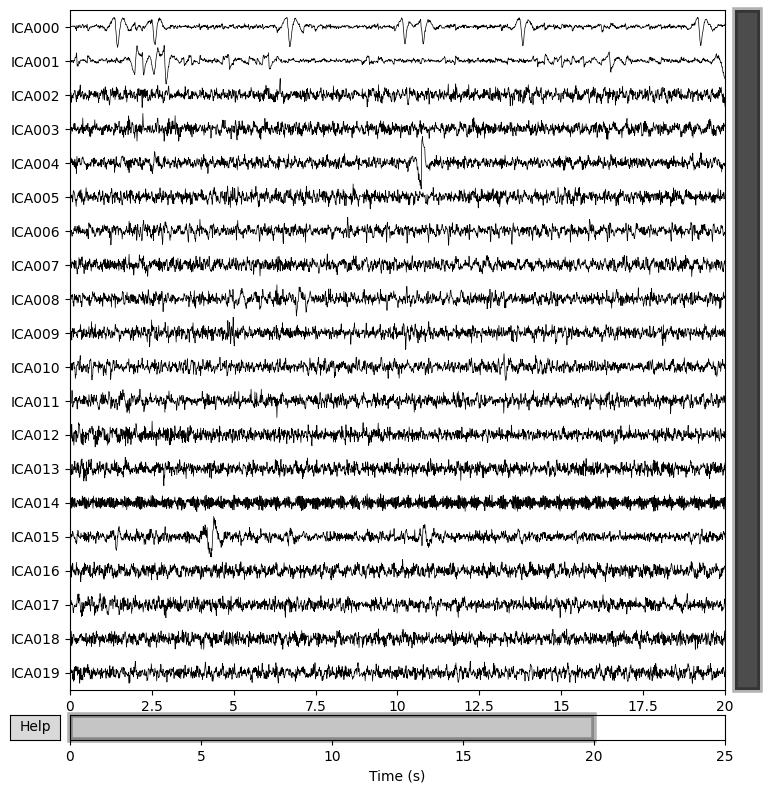

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


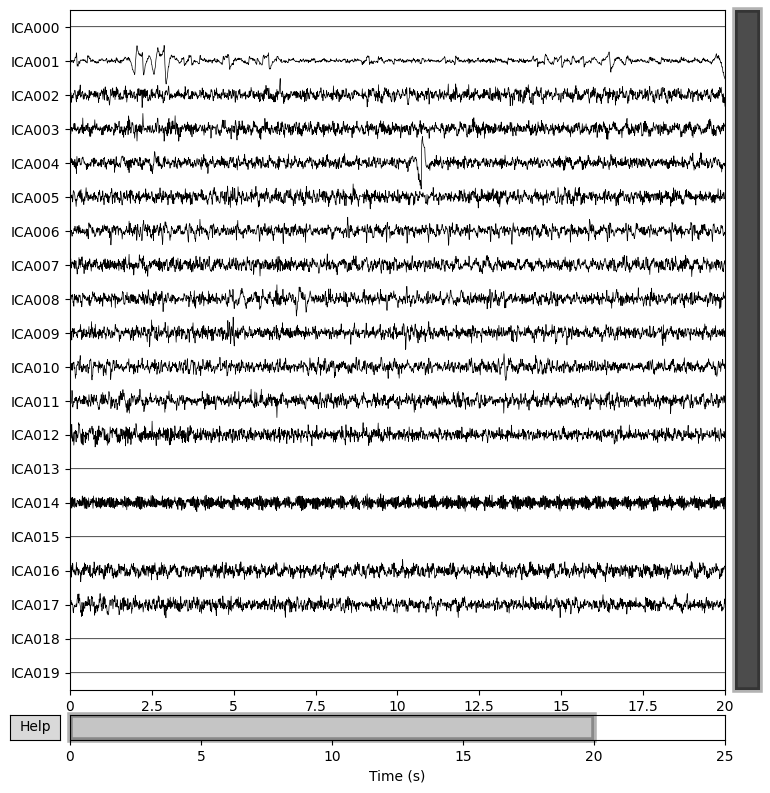

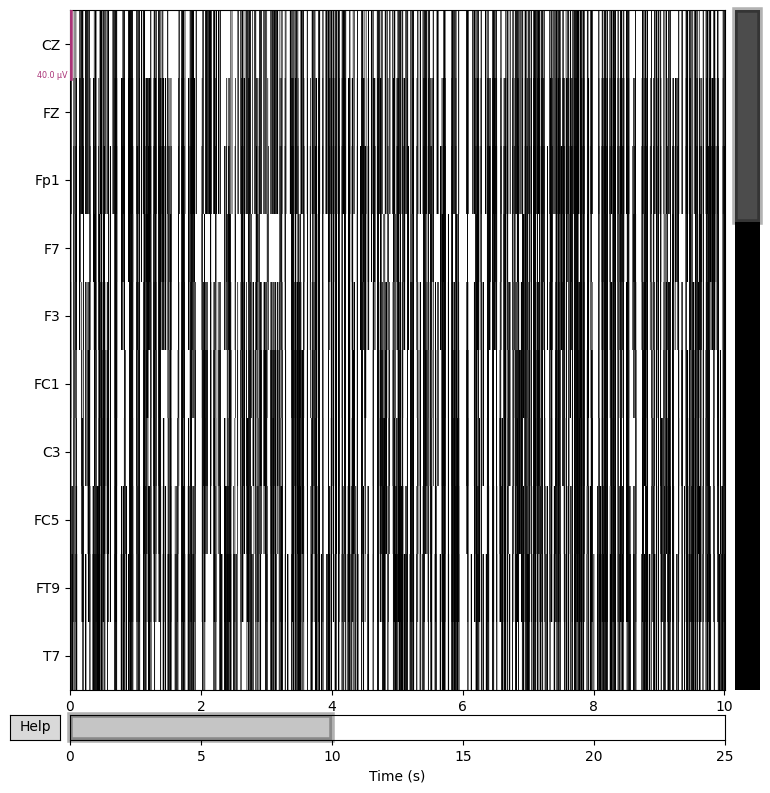

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective wind

In [ ]:
features_list_relax = []
labels_list_relax = []

for data_path in data_path_relax:
    raw, raw_ica = process_data(data_path, sfreq, ch_names, ch_types, excluded_components1)
    features_relax = extract_features(raw_ica, sfreq, win_length_sec=1, overlap_sec=0.5)
    labels_relax = np.zeros(features_relax.shape[0])
    features_list_relax.append(features_relax)
    labels_list_relax.append(labels_relax)

features_relax = np.concatenate(features_list_relax)
labels_relax = np.concatenate(labels_list_relax)

features_relax_train, features_relax_test, labels_relax_train, labels_relax_test = train_test_split(features_relax, labels_relax, test_size=0.5, random_state=42)

features_list_train.append(features_relax_train)
labels_list_train.append(labels_relax_train)

features_train = np.concatenate(features_list_train)
labels_train = np.concatenate(labels_list_train)

features_testx = features_relax_test
labels_testx = labels_relax_test

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Creating RawArray with float64 data, n_channels=32, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


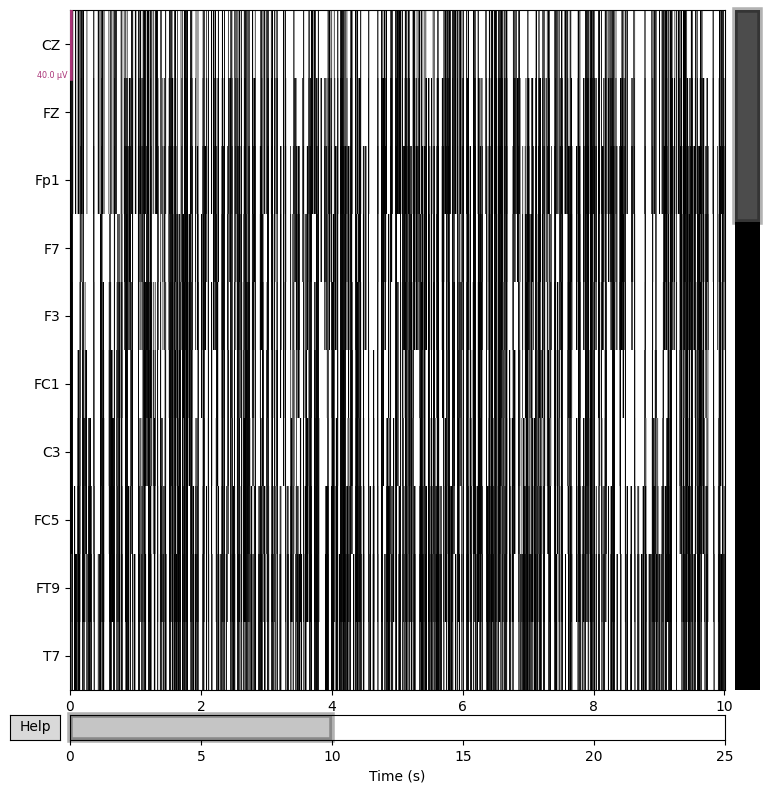

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Selecting by number: 20 components


<ipython-input-40-a43e21f775be>:32: RuntimeWarning: The data has not been high-pass filtered. For good ICA performance, it should be high-pass filtered (e.g., with a 1.0 Hz lower bound) before fitting ICA.
  ica.fit(raw)


Fitting ICA took 11.2s.
Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 0 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


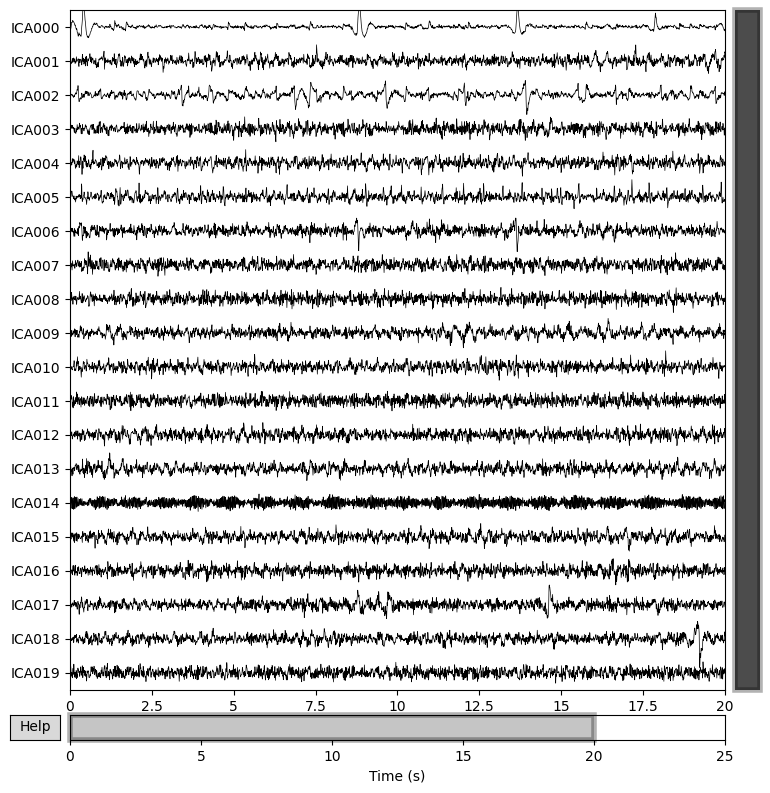

Applying ICA to Raw instance
    Transforming to ICA space (20 components)
    Zeroing out 5 ICA components
    Projecting back using 32 PCA components
Creating RawArray with float64 data, n_channels=20, n_times=3200
    Range : 0 ... 3199 =      0.000 ...    24.992 secs
Ready.


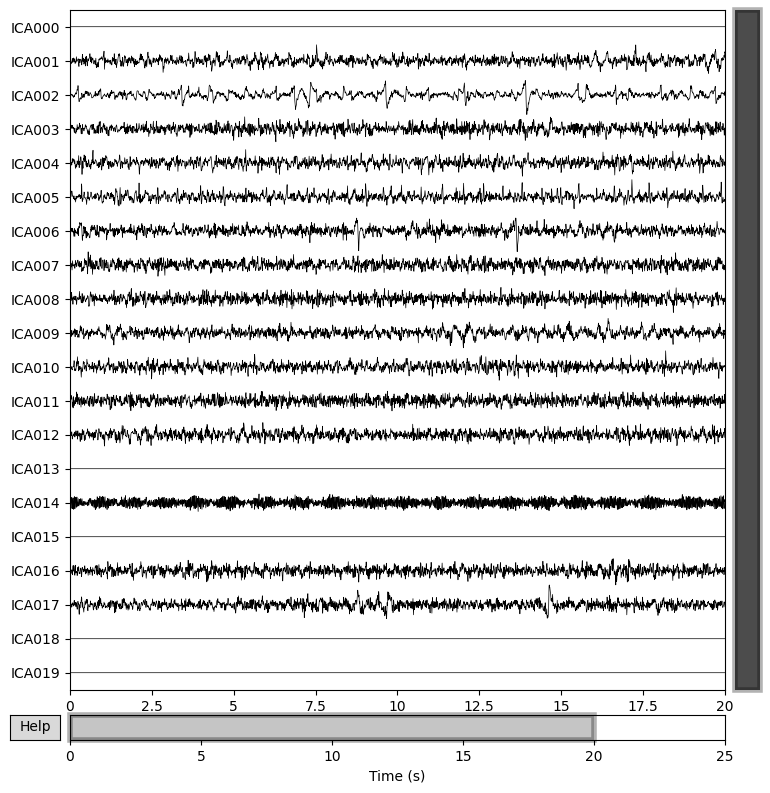

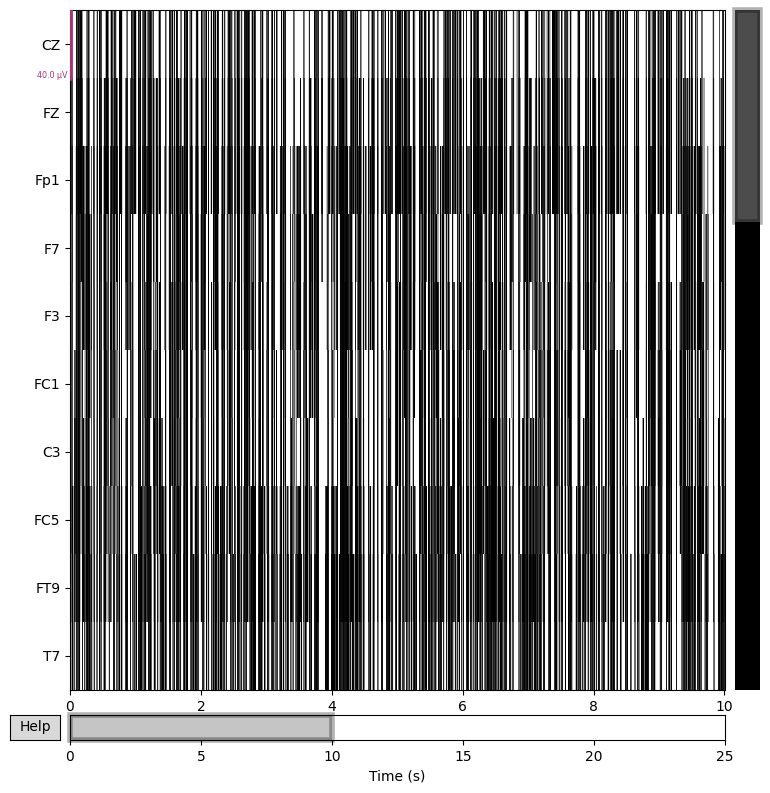

Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective window size : 1.000 (s)
Effective wind

In [ ]:
features_test_list = []
labels_test_list = []

for data_path in data_path_test:
    raw, raw_ica = process_data(data_path, sfreq, ch_names, ch_types, excluded_components1)
    features_test = extract_features(raw_ica, sfreq, win_length_sec=1, overlap_sec=0.5)
    labels_test = np.ones(features_test.shape[0])
    features_test_list.append(features_test)
    labels_test_list.append(labels_test)

features_test = np.concatenate(features_test_list)
features_test = np.concatenate([features_test, features_testx])
labels_test = np.concatenate(labels_test_list)
labels_test = np.concatenate([labels_test, labels_testx])

print(len(features_train))
print(len(features_test))
print(len(labels_train))
print(len(labels_test))

**Classification Workflow(Leave-One-Patient-Out (LOPO) cross-validation)**

In [ ]:
# Classify data
classify_data(features_train, features_test, labels_train, labels_test)

Training accuracy:  0.5920189504373178
Testing accuracy:  0.6466836734693877
              precision    recall  f1-score   support

         0.0       0.42      0.16      0.23       784
         1.0       0.68      0.89      0.77      1568

    accuracy                           0.65      2352
   macro avg       0.55      0.53      0.50      2352
weighted avg       0.59      0.65      0.59      2352

